In [1]:
import numpy as np
import matplotlib.pyplot as plt
import commpy as comm
import cmath
import numpy as np
import math
from scipy.sparse import coo_matrix
import os

common_path = './data/MIMO_decoding/di_mimo/'

path_to_all_instances = common_path + 'instances/'
path_to_all_solutions = common_path + 'ideal_solutions/'
path_to_all_solved = common_path + 'solved_solutions/'

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_instances)

if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_instances)
    print("Created new directory for problem instances")

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_solutions)

if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_solutions)
    print("Created new directory for solutions")

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_solved)

if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_solved)
    print("Created new directory for solutions")

## Create Instances

In [60]:
#N_t x N_r MIMO

N_t = 16                #Number Of Transmit antennas
N_r = 16                #Number of Receive antennas
modulation = 16         #Type of modulation
numInstances = 10000        #Number of Ising Instances to generate

bits_per_symbol = int(math.log2(modulation))

bitsPerEntry = int(0.5*bits_per_symbol)

maxQI = 2*np.sqrt(modulation/4) - 1

_qam = comm.QAMModem(modulation)

totalBits = bits_per_symbol*N_t

snr_list = [70,80,90,100] ## in dB

instance_type = "Nt"+str(N_t)+"_Nr"+str(N_r)+"_"+str(modulation)+"QAM/"

In [61]:
H = np.zeros((N_r,N_t),dtype=np.complex128)

# ## Seed for verification
# np.random.seed(1)

for snr in snr_list:
  path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
  path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_instances)

  if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path_to_instances)
      print("Created new directory for problem instances for snr ", snr)

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_solutions)

  if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path_to_solutions)
      print("Created new directory for ideal solutions for snr ", snr)

  ## Generate random channel matrices (complex)
  for k in range(numInstances):
    H = (1/np.sqrt(2))*(np.random.randn(N_r, N_t) + 1j*np.random.randn(N_r, N_t))

    ## Generate random transmissions
    x = np.zeros((N_t),dtype=np.complex128)

    for i in range(N_t):
      x[i] = _qam.modulate(comm.utilities.dec2bitarray(np.random.randint(0,modulation-1),bits_per_symbol))

    y = np.zeros((N_r),dtype=np.complex128)

    ## Find the corresponding received vectors
    y_rec = np.matmul(H,x)

    ## Add noise
    ey2 = np.mean(np.abs(y)**2)
    var = ey2/(10**(snr/10))
    y += np.sqrt(0.5) * (np.random.normal(scale=np.sqrt(var), size=(N_r)) + 1j*np.random.normal(scale=np.sqrt(var), size=(N_r)))

    temp = np.conjugate(H.T)@H
    noise_correction = (1/(10**(snr/10))) * np.identity(np.shape(H)[1])
    D = np.linalg.inv(temp + noise_correction)@(np.conjugate(H.T))

    x_mmse = _qam.modulate(_qam.demodulate(D@y_rec, "hard"))

    ## J is the internal field matrix for the Ising problem
    J = np.zeros((4*N_t,4*N_t))
    ## h is the external field. We can get rid of this by adding an 
    ## auxiliary spin (shown in paper)
    h = np.zeros((4*N_t))

    y = y_rec - H@x_mmse

    ## Transformation from complex matrices to real-valued matrices
    ## (refer to paper for more details)
    t1 = np.concatenate((H.real,-1*H.imag),axis=1)
    t2 = np.concatenate((H.imag, H.real),axis=1)

    H_r = np.concatenate((t1,t2),axis=0)
    y_r = np.concatenate((y.real,y.imag),axis=0)

    j_temp = H_r.T @ H_r
    J1 = np.hstack((j_temp, j_temp))
    J1 = -np.vstack((J1, J1))

    h_temp = 2*(y_r.T@H_r)
    h1 = np.concatenate((h_temp, h_temp), axis=0)

    np.fill_diagonal(J1, 0)

    max_J = np.absolute(J1).max()
    max_h = np.absolute(h1).max()

    ## Scale to keep all entries between -1 and 1
    scale = max(max_J,max_h)
    J = J1/scale
    h = h1/(2*scale)

    ## Save the expected solution
    with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "w") as file:
      #file.write("##\t"  + str(len(x)) + "\n")
      np.savetxt(file, x)

    with open(path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "w") as file:
      #file.write("##\t"  + str(len(x)) + "\n")
      np.savetxt(file, x_mmse)
    
    # Recast as pure quadratic and save for running in HLS
    h_reshaped = np.reshape(h, (1, 4*N_t))
    J_temp = np.vstack((J, h_reshaped))

    h_temp = h_reshaped.T
    h_temp = np.reshape(np.append(h_temp, 0), (4*N_t + 1, 1))
    J_quad = np.hstack((J_temp, h_temp))

    file = open(path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt", "w")
    np.savetxt(file, J_quad)
    file.close()

Created new directory for problem instances for snr  70
Created new directory for ideal solutions for snr  70
Created new directory for problem instances for snr  80
Created new directory for ideal solutions for snr  80
Created new directory for problem instances for snr  90
Created new directory for ideal solutions for snr  90
Created new directory for problem instances for snr  100
Created new directory for ideal solutions for snr  100


# Solver (matrix formulation)

In [76]:
def CIM_AHC_tf(T_time, J, time_step, r=0.2, beta=0.05, coupling_str=0.07, mu=1, noise=0, ground_energy=0, num_anneals = 1, target_a_baseline = 0.2, use_sign=0, gamma = 0.02, modulate_parameter="target_a", add_noise = 0, use_last = 0):

    N = J.shape[1]

    ticks = int(T_time/time_step) #actual number of steps
    plot_data = np.zeros((N, num_anneals, ticks))

    #r = Linear Gain
    #beta = Error Variable Rate of Change
    #coupling_str = Coupling Strength (F_J coefficient)
    target_a = target_a_baseline

    ## Turns out that the initilization makes a biiig difference!
    #x = 0.001 * np.random.rand(N, num_anneals) - 0.0005
    #error_var = np.abs(0.001 * np.random.rand(N, num_anneals) - 0.0005)

    x = np.sqrt(0.001) * np.random.normal(0,1,(N, num_anneals))
    error_var = np.abs(np.sqrt(0.001)* np.random.normal(0,1,(N, num_anneals)))
    etc_flag = np.ones((N, num_anneals))

    energies = np.zeros((num_anneals, ticks))

    for t in range(ticks):
        # print("\nTime Step ", t)
        # print("x = ", x)
        # print("e = ", error_var)

        if t > 1:
            prev_signs = np.sign(plot_data[:,:, t-1])
            compare_signs = prev_signs != np.sign(x)
            comparison = compare_signs.any()
            if comparison:
                etc_flag = error_var
            else:
                etc_flag = etc_flag #np.ones(N)

        if use_sign:
            MVM = (J).dot(np.sign(x))
        else:    
            MVM = (J).dot(x)
        # print("MVM = ", MVM)

        #Evolve Spin Variables
        xx = x**2
        x += (x*((r-1) - mu*xx)) * time_step
        x += coupling_str*(MVM*error_var) * time_step

        if add_noise == 1:
            x += np.sqrt(0.0005) * np.random.normal(0,1,(N, num_anneals))

        plot_data[:,:,t] = x 

        #Evolve Error Variables
        # xx = x**2
        error_var += -(beta*((xx) - target_a)*error_var) * time_step

        sig = np.sign(x)

        if modulate_parameter=="target_a":
            #Modulate Target Amplitude
            # delta_a = coupling_str*np.mean((J.dot(sig))*sig*etc_flag)
            delta_a = gamma*time_step
            target_a  = target_a_baseline + delta_a

        elif modulate_parameter=="coupling_str":
            coupling_str += time_step * gamma

        # plot_data[:,t] = x
        curr_ising_energy = np.diag(-1/2*(sig.T@J@sig))
        energies[:, t] = curr_ising_energy

    if use_last == 1:
        sol_time = -1
        best_anneal = np.argmin(energies[:,sol_time])

    else: 
        best_anneal = np.argmin(energies)//ticks
        sol_time = np.argmin(energies)%ticks

    best_energies = energies[best_anneal, :]
    best_plot_data = plot_data[:, best_anneal, :]
    best_sol = plot_data[:, best_anneal, sol_time]

    return (best_plot_data, best_energies, np.sign(best_sol), np.min(energies))

Text(0.5, 0, 'Time steps')

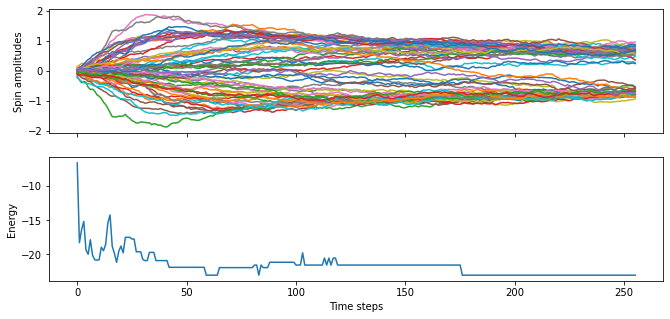

In [83]:
num_anneals = 64

N_steps = 256
time_step = 0.01
total_time = N_steps * time_step

r = 0.98
mu = 1
beta = 1
target_a_baseline = 0
gamma = 1/(N_steps * time_step)
coupling_str = 100

use_sign = 1
use_last = 0
add_noise = 1

# snr_list = [100]
numInstances = 500

# ## Seed for verification
# np.random.seed(1)

for snr in snr_list:
    path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
    path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
    path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_instances)

    if not isExist:
        print("No instances for snr = ", snr)
        break

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_solved)

    if not isExist:
        os.makedirs(path_to_solved)
        print("Created new directory for solved snr=", snr)

    for k in range(numInstances):
        file = open(path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt", "r")
        J = np.loadtxt(file)
        file.close()
        N = len(J)

        data, energies, solution, best_energy = CIM_AHC_tf(total_time, J, time_step=time_step, \
            r=r, mu = 1, beta=beta, target_a_baseline=target_a_baseline, \
                num_anneals=num_anneals, coupling_str=coupling_str, \
                use_sign=use_sign, gamma=gamma, modulate_parameter="target_a", add_noise=add_noise)  # target_a or coupling_str
        # print("Best energy = ", best_energy)
        file = open(path_to_solved +  "DI_MIMO_sol_" + str(k) + ".txt", "w")
        np.savetxt(file, solution, fmt="%s")
        file.close()

fig, ax = plt.subplots(2,1, sharex = True, figsize=(11,5))

for i in range(N):
    ax[0].plot(data[i,:])

ax[0].set_ylabel("Spin amplitudes")
ax[1].plot(energies)
ax[1].set_ylabel("Energy")
plt.xlabel("Time steps")

## Bit error rate

[0.0, 0.0, 0.0, 0.0]


Text(0, 0.5, 'BER')

c:\ProgramData\Anaconda3\envs\cornell\lib\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


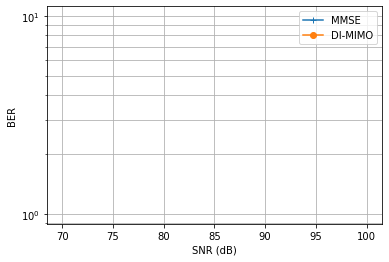

In [84]:
## This cell is to calculate the bit error rate once we have a solution

T = np.identity(2*N_t)
T = np.concatenate((T,T), axis=1)

ber = []
ber_mmse = []

for snr in snr_list:
  path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
  path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
  path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_instances)

  if not isExist:
      print("No instances for snr = ", snr)
      break
  
  isExist = os.path.exists(path_to_solved)

  if not isExist:
      print("No solved solutions for snr = ", snr)
      break
  bitErrors = 0
  bitErrors_mmse = 0

  #For Ising Solution s corresponding decoded symbol in
  for k in range(numInstances):
    # s = np.loadtxt(path_to_solved + "sol_" + str(k) + ".txt")
    file = open(path_to_solved + "DI_MIMO_sol_" + str(k) + ".txt", "r")
    s_quad = np.loadtxt(file)
    file.close()

    with open(path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "r") as file:
      x_mmse = np.loadtxt(file, dtype=np.complex128)

    s = s_quad[0:-1] * s_quad[-1]

    d = T@s
    x_mmse_r = np.concatenate((x_mmse.real,x_mmse.imag),axis=0)
    u = d + x_mmse_r

    u = u[0:N_t] + 1j*u[N_t:]

    b1 = _qam.demodulate(u,demod_type='hard')
    
    b_mmse = _qam.demodulate(x_mmse,demod_type='hard')

    with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "r") as file:
      x = np.loadtxt(file, dtype=np.complex128)

    b2 = _qam.demodulate(x,demod_type='hard')

    bitErrors = bitErrors + sum(abs(b1-b2))
    bitErrors_mmse = bitErrors_mmse + sum(abs(b_mmse-b2))
  
  ber.append(bitErrors/(totalBits*numInstances))
  ber_mmse.append(bitErrors_mmse/(totalBits*numInstances))

print(ber)

plt.semilogy(snr_list, ber_mmse, "+-")
plt.semilogy(snr_list, ber, "o-")
plt.legend(["MMSE", "DI-MIMO"])
plt.grid(True, which="both")
plt.xlabel("SNR (dB)")
plt.ylabel("BER")

[0.040078125, 0.02046875, 0.005390625, 0.00203125, 0.000234375, 0.0, 0.0]


Text(0, 0.5, 'BER')

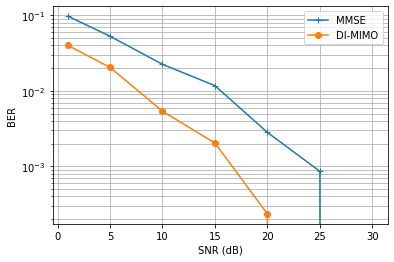

In [56]:
## This cell is to calculate the bit error rate once we have a solution

T = np.identity(2*N_t)
T = np.concatenate((T,T), axis=1)

ber = []
ber_mmse = []

for snr in snr_list:
  path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
  path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
  path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_instances)

  if not isExist:
      print("No instances for snr = ", snr)
      break
  
  isExist = os.path.exists(path_to_solved)

  if not isExist:
      print("No solved solutions for snr = ", snr)
      break
  bitErrors = 0
  bitErrors_mmse = 0

  #For Ising Solution s corresponding decoded symbol in
  for k in range(numInstances):
    # s = np.loadtxt(path_to_solved + "sol_" + str(k) + ".txt")
    file = open(path_to_solved + "DI_MIMO_sol_" + str(k) + ".txt", "r")
    s_quad = np.loadtxt(file)
    file.close()

    with open(path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "r") as file:
      x_mmse = np.loadtxt(file, dtype=np.complex128)

    s = s_quad[0:-1] * s_quad[-1]

    d = T@s
    x_mmse_r = np.concatenate((x_mmse.real,x_mmse.imag),axis=0)
    u = d + x_mmse_r

    u = u[0:N_t] + 1j*u[N_t:]

    b1 = _qam.demodulate(u,demod_type='hard')
    
    b_mmse = _qam.demodulate(x_mmse,demod_type='hard')

    with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "r") as file:
      x = np.loadtxt(file, dtype=np.complex128)

    b2 = _qam.demodulate(x,demod_type='hard')

    bitErrors = bitErrors + sum(abs(b1-b2))
    bitErrors_mmse = bitErrors_mmse + sum(abs(b_mmse-b2))
  
  ber.append(bitErrors/(totalBits*numInstances))
  ber_mmse.append(bitErrors_mmse/(totalBits*numInstances))

print(ber)

plt.semilogy(snr_list, ber_mmse, "+-")
plt.semilogy(snr_list, ber, "o-")
plt.legend(["MMSE", "DI-MIMO"])
plt.grid(True, which="both")
plt.xlabel("SNR (dB)")
plt.ylabel("BER")

In [ ]:
# modify pathnames as needed (path_to_solutions, base_dir, base_file_name, read_path_mmse, read_path_sol_correct)

snr = 30
instance_type = "Nt"+str(N_t)+"_Nr"+str(N_r)+"_"+str(modulation)+"QAM/"
path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
path_to_solutions = "C:/users/ari/AppData/Roaming/Xilinx/Vitis/6775_final_demo/solution1/csim/build/"
numProbsTest = 10



base_dir = "C:/Users/ari/Documents/di_mimo/solved_solutions/"
#C:\Users\ari\Documents\di_mimo\hls_sols\DI_MIMO_J_Conv_6_19_23_2_0_sol.txt
#base_file_name = "DI_MIMO_J_Conv_6_19_23_2_" 

#base_file_name = "DI_MIMO_J_Conv_snr_30_18_2_"
#base_file_name = "DI_MIMO_sol_AHC_stand_30_"

#base_file_name = "DI_MIMO_sol_AHC_stand_30_"
base_file_name = "best_spins_"


#for 100 annels 256
#this cell is to calculate the bit error rate once we have a solution
bitErrors = 0

T = np.identity(2*N_t)
T = np.concatenate((T,T), axis=1)
# print(T.shape)

print(numProbsTest)

path_to_solutions = "C:/users/ari/AppData/Roaming/Xilinx/Vitis/6775_final_demo/solution1/csim/build/"


read_path_mmse = 'C:/Users/ari/Documents/di_mimo/ideal_solutions/Nt16_Nr16_16QAM/30/'
read_path_sol_correct = 'C:/Users/ari/Documents/di_mimo/ideal_solutions/Nt16_Nr16_16QAM/30/'

bitErrorInstancesNumbers = []
ber = []
ber_mmse = []



snr_list = [1, 5, 10, 15, 20, 25, 30]

for snr in snr_list:
  bitErrors = 0
  bitErrors_mmse = 0

  #For Ising Solution s corresponding decoded symbol in
  for k in range(0, numProbsTest):
    # s = np.loadtxt(path_to_solved + "sol_" + str(k) + ".txt")
    #file = open(path_to_all_solved + "DI_MIMO_sol_LFSR" + str(k) + ".txt", "r")

    #file = open(path_to_all_solved + str(snr)+ "DI_MIMO_sol_AHC_stand" + str(k)+ ".txt", "r")

    #print('k is: ' + str(k))

    path_to_solutions = 'C:/Users/ari/Documents/di_mimo/solved_solutions/'
    read_path_mmse = 'C:/Users/ari/Documents/di_mimo/ideal_solutions/Nt16_Nr16_16QAM/' + str(snr) + '/'
    read_path_sol_correct = 'C:/Users/ari/Documents/di_mimo/ideal_solutions/Nt16_Nr16_16QAM/' + str(snr) + '/'
    base_file_name = "DI_MIMO_sol_AHC_stand_" + str(snr) + "_" 

    file = open(path_to_solutions + base_file_name + str(k) + ".txt", "r")
    file.seek(1)
    s_quad = np.loadtxt(file)
    file.close()



    with open(read_path_mmse + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "r") as file:
      x_mmse = np.loadtxt(file, dtype=np.complex128)

    s = s_quad[0:-1] * s_quad[-1]
    # print(s)
    # print(s.shape)
    d = T@s
    x_mmse_r = np.concatenate((x_mmse.real,x_mmse.imag),axis=0)
    u = d + x_mmse_r

    u = u[0:N_t] + 1j*u[N_t:]

    b1 = _qam.demodulate(u,demod_type='hard')

    b_mmse = _qam.demodulate(x_mmse,demod_type='hard')

    with open(read_path_sol_correct + "DI_MIMO_sol_" + str(k) + ".txt", "r") as file:
      x = np.loadtxt(file, dtype=np.complex128)
      

    b2 = _qam.demodulate(x,demod_type='hard')
    #if(sum(abs(b1-b2)) != 0):
      #berValues.append((b1-b2)/totalBits)
      #bitErrorInstancesNumbers.append(k)
      #print(k)


  bitErrors_mmse = bitErrors_mmse + sum(abs(b_mmse-b2))

  bitErrors = bitErrors + sum(abs(b1-b2))
  bitErrors_mmse = bitErrors_mmse + sum(abs(b_mmse-b2))
  
  ber.append(bitErrors/(totalBits*numInstances))
  ber_mmse.append(bitErrors_mmse/(totalBits*numInstances))


    

print(ber)
print(ber_mmse)
plt.semilogy(snr_list, ber_mmse, "+-")
plt.semilogy(snr_list, ber, "o-")
plt.legend(["MMSE", "DI-MIMO"])
plt.grid(True, which="both")
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.savefig('snr_plot.pdf', format='pdf')